# <b>Projekt 1. - Symulator Tomografu</b>
### <b>Autorzy:</b> Wiktoria Białasik 151436, Mateusz Czechowski 155921

## <u>Zastosowany język programowania oraz użyte biblioteki</u>
<p>     lorem ipsum xd </p>

In [123]:
#pip3 install -U scikit-learn scipy matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
import numpy as np
import pydicom
import datetime
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from PIL import Image
import os
import ipywidgets as widgets
from IPython.display import display, clear_output 
from matplotlib import colors
import re
from ipywidgets import interact
import scipy.ndimage
from scipy import signal
from scipy.ndimage import convolve
from sklearn.metrics import mean_squared_error
import cv2
import time

In [ ]:
def on_select(change):
    global file_type
    file_type = change['new']
    print(f'Wybrano: {file_type}')

file_selector = widgets.Dropdown(
    options=['JPG', 'DCIM'],
    description='Wybierz:',
    disabled=False,
)

file_selector.observe(on_select, names='value')
display(file_selector)

apply_filtering = widgets.Checkbox(value=False, description="Używanie filtrowania")
display(apply_filtering)

Dropdown(description='Wybierz:', options=('JPG', 'DCIM'), value='JPG')

Checkbox(value=False, description='Używanie filtrowania')

Dropdown(description='Pick image', index=6, options=('CT_ScoutView-large.jpg', 'CT_ScoutView.jpg', 'Kolo.jpg',…

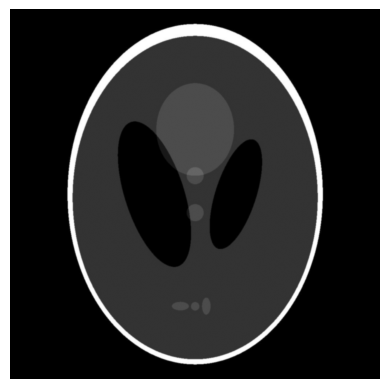

In [124]:
image = None
filename = ''
type = file_selector.value

sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

blur_kernel = np.array([[1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1]]) / 9.0

edge_kernel = np.array([[-1, -1, -1],
                        [-1, 9, -1],
                        [-1, -1, -1]], dtype='float')

if type == "JPG":
    examples_dir='example-data/png/'
    examples_list = [file for file in os.listdir(examples_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]
else:
    examples_dir='example-data/dicom/'
    examples_list = [file for file in os.listdir(examples_dir) if file.endswith(('.dcm'))]
    

filename_picker = widgets.Dropdown(
    options=examples_list,
    description="Pick image",
    disabled=False
)

def show(change):
    global image
    global filename
    clear_output(wait=True)
    display(filename_picker)
    selected_file = change['new']
    
    if selected_file:
        file_path = os.path.join(examples_dir, selected_file)
    
        if type == "JPG":
            image = mpimg.imread(file_path)
            if len(image.shape) == 3:
                image = np.mean(image, axis=2)
        else:
            dicom_data = pydicom.dcmread(file_path)
            image = dicom_data.pixel_array.astype(np.float32)

            image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
            image = image.astype(np.uint8)
        
        if apply_filtering:
            #padding = int(image.shape[0]/2)
            #color=(0, 0, 0)
            #image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=color)
            #image = signal.convolve2d(image, edge_kernel)
            #image = image[2:-2,2:-2]
            image = scipy.ndimage.gaussian_filter(image, sigma=1)
            #image = scipy.ndimage.median_filter(image, size=3)
        
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.show()
        filename = os.path.splitext(filename_picker.value)[0]
        print(filename)

filename_picker.observe(show, names='value')
display(filename_picker)

In [125]:
def bresenham_algorithm(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))  
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

In [126]:
def compute_geometry(image_shape):
    x_center = image_shape[0] / 2
    y_center = image_shape[1] / 2
    radius = np.sqrt(x_center**2 + y_center**2)
    return x_center, y_center, radius

In [127]:
step_widget = widgets.IntSlider(value=1, min=1, max=6, step=1, description='Krok ∆α:')
detector_count_widget = widgets.IntSlider(value=180, min=90, max=420, step=10, description='Liczba detektorów:')
span_widget = widgets.IntSlider(value=180, min=90, max=360, step=90, description='Rozwartość (l):')

display(step_widget, detector_count_widget, span_widget)

step = step_widget.value
detector_count = detector_count_widget.value
span = span_widget.value

IntSlider(value=1, description='Krok ∆α:', max=6, min=1)

IntSlider(value=180, description='Liczba detektorów:', max=420, min=90, step=10)

IntSlider(value=180, description='Rozwartość (l):', max=360, min=90, step=90)

In [130]:
def radon_transform(image, step, detectors_num, span, filename):
    step = np.radians(step)  
    span = np.radians(span)
    x_center, y_center, radius = compute_geometry(image.shape)
    sinogram = np.zeros((int(2 * np.pi / step), detectors_num))
    print(2 * np.pi / step)
    sinogram_snapshot = []
    
    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = [int(x_center + radius * np.cos(angle)), int(y_center + radius * np.sin(angle))]
        
        detector_first_pos = angle + np.pi - span / 2
        detector_last_pos = angle + np.pi + span / 2
        det_angles = np.linspace(detector_first_pos, detector_last_pos, detectors_num)
        
        for det_idx, det_angle in enumerate(det_angles):
            det_pos = [int(x_center + radius * np.cos(det_angle)), int(y_center + radius * np.sin(det_angle))]
            points = list(bresenham_algorithm(emitter_pos[0], emitter_pos[1], det_pos[0], det_pos[1]))
            
            bright_points = sum(1 for p in points if 0 <= p[0] < image.shape[0] and 0 <= p[1] < image.shape[1])
            sum_bright = sum(image[p[0], p[1]] for p in points if 0 <= p[0] < image.shape[0] and 0 <= p[1] < image.shape[1])
            
            sinogram[i, det_idx] = sum_bright / bright_points if bright_points > 0 else 0

        if i%10 == 0 or i == sinogram.shape[0]-1:
            s_scaled = (255.0 / np.amax(sinogram)) * sinogram
            s_scaled =  s_scaled.astype(np.uint8)
            s_image =  Image.fromarray(s_scaled.T, mode='L')
            s_resized = s_image.resize((image.shape[1], image.shape[0]), resample=Image.NEAREST)
            sinogram_snapshot.append(s_resized)


    sinogram_scaled = (255.0 / np.amax(sinogram)) * sinogram
    sinogram_scaled = sinogram_scaled.astype(np.uint8)
    sinogram_image = Image.fromarray(sinogram_scaled.T, mode='L')
    sinogram_resized = sinogram_image.resize((image.shape[1], image.shape[0]), resample=Image.NEAREST)
    sinogram_resized.save(f'results/sinograms/{filename}.png')
    plt.imshow(sinogram_resized, cmap="gray")
    plt.axis('off')
    plt.show()

    return sinogram, sinogram_snapshot

sinogram, sinogram_snapshots = radon_transform(image, step, detector_count, span, filename)

360.0


KeyboardInterrupt: 

In [75]:
def display_sinogram(step):
    plt.imshow(sinogram_snapshots[step], cmap="gray")
    plt.axis('off')
    plt.show()
    
slider = widgets.IntSlider(value=0, min=0, max=len(sinogram_snapshots) - 1, step=1)
interact(display_sinogram, step=slider)


interactive(children=(IntSlider(value=0, description='step', max=36), Output()), _dom_classes=('widget-interac…

<function __main__.display_sinogram(step)>

Obraz Wyjściowy


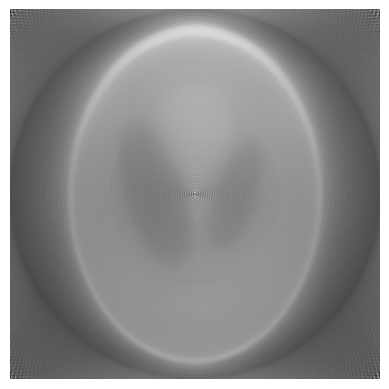

In [129]:
def inverse_radon_transform(sinogram, image_shape, step, span, filename):
    x_center, y_center, radius = compute_geometry(image_shape)
    step = np.radians(step)
    span = np.radians(span)
    
    result = np.zeros(image_shape)
    norm_matrix = np.zeros(image_shape)

    output_dir = 'results/template_images/'
    os.makedirs(output_dir, exist_ok=True)

    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = [int(x_center + radius * np.cos(angle)), int(y_center + radius * np.sin(angle))]
        
        for j in range(sinogram.shape[1]):
            det_angle = angle + np.pi - span / 2 + j * span / sinogram.shape[1]
            det_pos = [int(x_center + radius * np.cos(det_angle)), int(y_center + radius * np.sin(det_angle))]
            
            points = list(bresenham_algorithm(emitter_pos[0], emitter_pos[1], det_pos[0], det_pos[1]))
            
            for point in points:
                if 0 <= point[0] < image_shape[0] and 0 <= point[1] < image_shape[1]:
                    result[point[0], point[1]] += sinogram[i, j]
                    norm_matrix[point[0], point[1]] += 1

        if i % 10 == 0:  
            temp_result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix!=0)
            temp_result_scaled = (255.0 / np.amax(temp_result)) * temp_result
            temp_image = Image.fromarray(temp_result_scaled.astype(np.uint8), mode='L')
            temp_image.save(f'{output_dir}step_{i}.png')
    
    result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix!=0)
    
    result_scaled = (255.0 / np.amax(result)) * result
    result_image = Image.fromarray(result_scaled.astype(np.uint8), mode='L')
    result_image.save(f'results/recovered_images/png/{filename}.png')

    print("Obraz Wyjściowy")
    plt.imshow(result_image, cmap="gray")
    plt.axis('off')
    plt.show()

    return result

result = inverse_radon_transform(sinogram, image.shape, 1, 180, filename)



In [ ]:
print("Postęp generowania obrazu wyjściowegp")
image_folder = "results/template_images/"
def extract_number(filename):
    match = re.search(r"step_(\d+).png", filename)
    return int(match.group(1)) if match else float('inf')

images = sorted(
    [img for img in os.listdir(image_folder) if img.endswith('.png')],
    key=extract_number
)

slider = widgets.IntSlider(min=0, max=len(images)-1, step=1, description="Krok")

def update_image(step):
    img = plt.imread(os.path.join(image_folder, images[step]))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

widgets.interactive(update_image, step=slider)

Postęp generowania obrazu wyjściowegp


interactive(children=(IntSlider(value=0, description='Krok', max=35), Output()), _dom_classes=('widget-interac…

In [114]:
for f in os.listdir(image_folder):
    file_path = os.path.join(image_folder, f)
    if f.endswith(".png") and os.path.isfile(file_path):
        os.remove(file_path)

In [79]:
png_dir = "results/recovered_images/png/"
dicom_dir = "results/recovered_images/dicom/"

def save_png(image_array, filename):
    image = Image.fromarray(image_array.astype(np.uint8), mode='L')
    image.save(f"{png_dir}{filename}.png")

def save_dicom(image_array, filename, patient_name, patient_id, date, comment):
    ds = Dataset()
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.StudyDate = date
    ds.ImageComments = comment

    ds.Rows, ds.Columns = image_array.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0

    ds.Modality = "OT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()

    ds.file_meta = FileMetaDataset()
    ds.file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    ds.file_meta.MediaStorageSOPInstanceUID = ds.SOPInstanceUID
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    ds.PixelData = image_array.tobytes()

    ds.save_as(filename, write_like_original=False)


format_selector = widgets.Dropdown(
    options=["PNG", "DICOM"],
    value="PNG",
    description="Format:",
)

filename_input = widgets.Text(value= filename, description="Nazwa pliku:")
patient_name_input = widgets.Text(description="Pacjent:")
patient_id_input = widgets.Text(description="ID Pacjenta:")
address_input = widgets.Text(description="Adres:")
date_input = widgets.Text(description="Data:")
comment_input = widgets.Text(description="Komentarz:")

dicom_fields = widgets.VBox([
    patient_name_input, patient_id_input, address_input, date_input, comment_input
])

save_button = widgets.Button(description="Zapisz obraz")

def save_image(_):
    filename = filename_input.value
    image_array = np.array(result, dtype=np.uint8)

    if format_selector.value== "PNG":
        save_png(image_array, filename)
    else:
        save_dicom(
            image_array, 
            filename, 
            patient_name_input.value, 
            patient_id_input.value, 
            address_input.value, 
            date_input.value, 
            comment_input.value
        )

save_button.on_click(save_image)

def update_fields(change):
    if format_selector.value == "DICOM":
        dicom_fields.layout.display = 'block'
    else:
        dicom_fields.layout.display = 'none'


dicom_fields.layout.display = 'none'

display(format_selector, filename_input, dicom_fields, save_button)
format_selector.observe(update_fields, names="value")

Dropdown(description='Format:', options=('PNG', 'DICOM'), value='PNG')

Text(value='Shepp_logan', description='Nazwa pliku:')

Button(description='Zapisz obraz', style=ButtonStyle())

# Wykonany Eksperyment

In [131]:
def radon_transform(image, step, detectors_num, span, scans):
    step = np.radians(step)  
    span = np.radians(span)
    x_center, y_center, radius = compute_geometry(image.shape)
    sinogram = np.zeros((scans*2, detectors_num))

    
    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = [int(x_center + radius * np.cos(angle)), int(y_center + radius * np.sin(angle))]
        
        detector_first_pos = angle + np.pi - span / 2
        detector_last_pos = angle + np.pi + span / 2
        det_angles = np.linspace(detector_first_pos, detector_last_pos, detectors_num)
        
        for det_idx, det_angle in enumerate(det_angles):
            det_pos = [int(x_center + radius * np.cos(det_angle)), int(y_center + radius * np.sin(det_angle))]
            points = list(bresenham_algorithm(emitter_pos[0], emitter_pos[1], det_pos[0], det_pos[1]))
            
            bright_points = sum(1 for p in points if 0 <= p[0] < image.shape[0] and 0 <= p[1] < image.shape[1])
            sum_bright = sum(image[p[0], p[1]] for p in points if 0 <= p[0] < image.shape[0] and 0 <= p[1] < image.shape[1])
            
            sinogram[i, det_idx] = sum_bright / bright_points if bright_points > 0 else 0

    return sinogram

def inverse_radon_transform(sinogram, image_shape, step, span):
    x_center, y_center, radius = compute_geometry(image_shape)
    step = np.radians(step)
    span = np.radians(span)
    
    result = np.zeros(image_shape)
    norm_matrix = np.zeros(image_shape)

    output_dir = 'results/template_images/'
    os.makedirs(output_dir, exist_ok=True)

    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = [int(x_center + radius * np.cos(angle)), int(y_center + radius * np.sin(angle))]
        
        for j in range(sinogram.shape[1]):
            det_angle = angle + np.pi - span / 2 + j * span / sinogram.shape[1]
            det_pos = [int(x_center + radius * np.cos(det_angle)), int(y_center + radius * np.sin(det_angle))]
            
            points = list(bresenham_algorithm(emitter_pos[0], emitter_pos[1], det_pos[0], det_pos[1]))
            
            for point in points:
                if 0 <= point[0] < image_shape[0] and 0 <= point[1] < image_shape[1]:
                    result[point[0], point[1]] += sinogram[i, j]
                    norm_matrix[point[0], point[1]] += 1

    result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix!=0)
    
    result_scaled = (255.0 / np.amax(result)) * result
    result_image = Image.fromarray(result_scaled.astype(np.uint8), mode='L')

    plt.imshow(result_image, cmap="gray")
    plt.axis('off')
    plt.show()

    return result

In [132]:
### BASIC ###
# dets - 180
# scans - 180
# fan - 180

dets = [i for i in range(90, 721, 90)]
scans = [i for i in range(90, 721, 90)]
fans = [i for i in range(45, 271, 45)]

rmse_dets = []
rmse_scans = []
rmse_fans = []

test_img = np.array(Image.open("./example-data/png/Shepp_logan.jpg").convert("L"))

def calc_RMSE(org, rec):
    mse = np.sqrt(np.mean((org - rec) ** 2))
    mse = mse/(org.shape[0]*org.shape[1])
    rmse = mse**0.5
    return rmse

for d in dets:
    sin = radon_transform(test_img, 1, d, 180, 180)
    rec = inverse_radon_transform(sin, test_img.shape, 1, 180)
    rmse = calc_RMSE(test_img, rec)
    print(rmse)
    rmse_dets.append(rmse)

plt.figure()
plt.plot(dets, rmse_dets, label='RMSE dla detektorów')
plt.xlabel('Liczba detektorów')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

for s in scans:
    sin = radon_transform(test_img, 1, 180, 180, s)
    rec = inverse_radon_transform(sin, test_img.shape, 1, 180)
    rmse = calc_RMSE(test_img, rec)
    print(rmse)
    rmse_scans.append(rmse)

plt.figure()
plt.plot(scans, rmse_scans, label='RMSE dla skanów')
plt.xlabel('Liczba skanów')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

for f in fans:
    sin = radon_transform(test_img, 1, 180, f, 180)
    rec = inverse_radon_transform(sin, test_img.shape, 1, f)
    rmse = calc_RMSE(test_img, rec)
    rmse_fans.append(rmse)

plt.figure()
plt.plot(fans, rmse_fans, label='RMSE dla rozpętości wachlarza')
plt.xlabel('Rozpiętość wachlarza')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()




C:\Users\Mateusz\AppData\Local\Temp\ipykernel_27260\3517821885.py:21: RuntimeWarning: overflow encountered in scalar add
  sum_bright = sum(image[p[0], p[1]] for p in points if 0 <= p[0] < image.shape[0] and 0 <= p[1] < image.shape[1])


KeyboardInterrupt: 